In [1]:
!python --version

Python 3.10.13


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as ks
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import os
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
tf.__version__

'2.14.0'

In [4]:
ks.__version__

'2.14.0'

In [5]:
# MNIST Data Loader Class

class MnistDataloader:
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [6]:
def plot_random_samples(n_samples: int=9, width: int=10, height: int=10)->None:
    n_samples=1 if n_samples<1 else n_samples
    remainder=n_samples%3
    n_rows=np.ceil(n_samples/3).astype(int) if n_samples > 3 else 1
    n_cols=3 if n_samples >= 3 else n_samples
    print(f'No of columns: {n_cols} | No. of rows: {n_rows} | No. of samples: {n_samples}'.center(os.get_terminal_size().columns))

    fig = plt.figure(figsize=(width, height))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(n_samples):
        img_no = np.random.randint(0, len(X))
        img_label = Y[img_no]
        img_label = 0 if int(img_label) == 10 else img_label
        img = X[img_no]
        # create subplot and append to ax
        ax.append(fig.add_subplot(n_rows, n_cols, i+1))
        # set title
        ax[-1].set_title(img_label)
        ax[-1].axis('off')
        fig.tight_layout()
        plt.imshow(img, cmap='gray')
    plt.show();

In [7]:
def plot_random_predictions(model, n_samples: int=9, width: int=10, height: int=10)->None:
    n_samples=1 if n_samples<1 else n_samples
    remainder=n_samples%3
    n_rows=np.ceil(n_samples/3).astype(int) if n_samples > 3 else 1
    n_cols=3 if n_samples >= 3 else n_samples
    print(f'No of columns: {n_cols} | No. of rows: {n_rows} | No. of samples: {n_samples}'.center(os.get_terminal_size().columns))

    fig = plt.figure(figsize=(width, height))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(n_samples):
        img_no = np.random.randint(0, len(X))
        img_label = Y[img_no]
        img = X[img_no]
        prediction = model.predict(img.reshape(1, -1), verbose=0)
        predicted_label = np.argmax(prediction > 0.5)
        prediction_percentage = np.round(prediction[0][predicted_label]*100, 2)
        # create subplot and append to ax
        ax.append(fig.add_subplot(n_rows, n_cols, i+1))
        # set title
        ax[-1].set_title(f'Predicted: {predicted_label} | {prediction_percentage}%\nTrue: {img_label}', fontsize=9, color="green" if img_label==predicted_label else "red")
        ax[-1].axis('off')
        fig.tight_layout()
        plt.imshow(img, cmap='gray')
    plt.show();

In [8]:
def plot_auc_scores(clf, X_test, y_test, Y):
    y_test_bin = label_binarize(y_test, classes=np.unique(Y).tolist())
    n_classes = y_test_bin.shape[1]
    y_score = clf.predict(X_test)
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def normalize_images(X):
    return X/255

In [10]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest, y):
    encoder = np.unique(y)
    
    visualizer = ROCAUC(model, encoder=encoder, size=(1080, 720))
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [11]:
input_path = './'
training_images_filepath = join(input_path, './train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, './train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, './t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, './t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [12]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [13]:
X = np.concatenate((np.array(x_train),np.array(x_test)))
Y = np.concatenate((np.array(y_train),np.array(y_test)))
X = normalize_images(X)

                                 No of columns: 3 | No. of rows: 3 | No. of samples: 9                                  


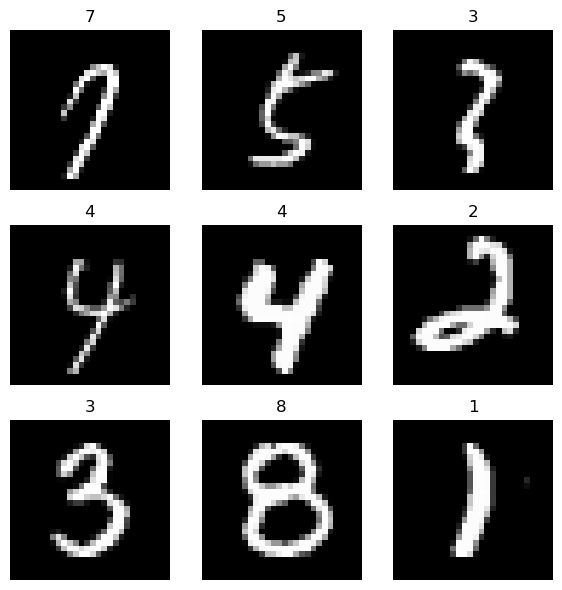

In [14]:
plot_random_samples(n_samples=9, width=6, height=6)

In [15]:
IMG_SIZE = np.array(X[0]).shape
print('Image size: ', IMG_SIZE)

Image size:  (28, 28)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, shuffle=True)

In [17]:
# Initialising the ANN
NO_NEURONS = 128

clf = Sequential()

clf.add(Flatten(input_shape=IMG_SIZE))
clf.add(Dense(units = NO_NEURONS))
clf.add(Dropout(0.2))
clf.add(Dense(units = NO_NEURONS))
clf.add(Dropout(0.2))
clf.add(Dense(units = len(np.unique(Y)), activation='softmax'))

clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 11828

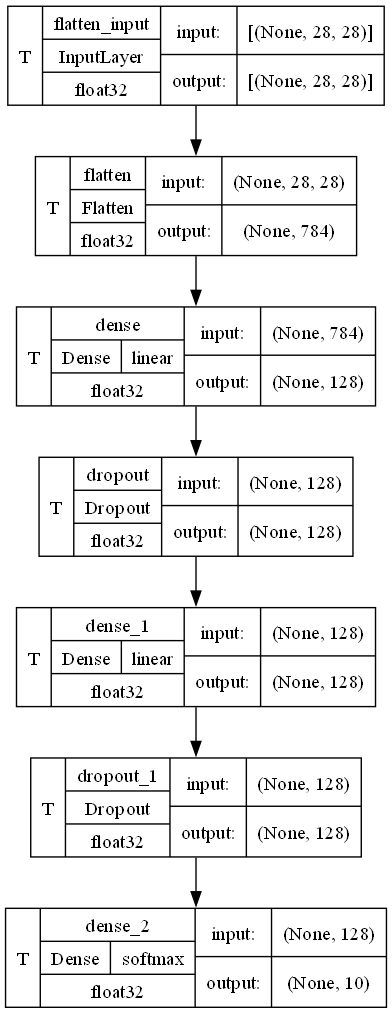

In [18]:
ks.utils.plot_model(
    clf,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True,
)

In [19]:
clf.compile(optimizer = ks.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics='accuracy')

In [20]:
history = clf.fit(X_train, y_train, epochs = 50, batch_size = 1, validation_data=(X_test, y_test))

Epoch 1/50
56000/56000 [==============================] - 63s 1ms/step - loss: 0.4137 - accuracy: 0.8801 - val_loss: 0.3245 - val_accuracy: 0.9108
Epoch 2/50
56000/56000 [==============================] - 62s 1ms/step - loss: 0.3395 - accuracy: 0.9041 - val_loss: 0.3159 - val_accuracy: 0.9114
Epoch 3/50
56000/56000 [==============================] - 61s 1ms/step - loss: 0.3243 - accuracy: 0.9103 - val_loss: 0.3153 - val_accuracy: 0.9137
Epoch 4/50
56000/56000 [==============================] - 60s 1ms/step - loss: 0.3153 - accuracy: 0.9109 - val_loss: 0.3106 - val_accuracy: 0.9149
Epoch 5/50
56000/56000 [==============================] - 60s 1ms/step - loss: 0.3090 - accuracy: 0.9135 - val_loss: 0.3079 - val_accuracy: 0.9161
Epoch 6/50
56000/56000 [==============================] - 60s 1ms/step - loss: 0.3051 - accuracy: 0.9142 - val_loss: 0.3005 - val_accuracy: 0.9186
Epoch 7/50
56000/56000 [==============================] - 60s 1ms/step - loss: 0.3027 - accuracy: 0.9154 - val_loss: 0

438/438 [==============================] - 0s 749us/step
Accuracy:  90.44285714285715
[[1334    0    3    2    1   23   19    0    5    0]
 [  16 1536    7    2    2    1    2    3   11    0]
 [  31   16 1295   10   16    4   17    9   44    1]
 [  58    4   66 1187    1   50    3   12   47    7]
 [  30    3    8    1 1253    3   16    8    6   22]
 [  52    6    8   24    8 1044   24    2   56    7]
 [  19    4    9    1   10   14 1321    1    8    0]
 [  44    5   31    1   15    2    1 1316    7   36]
 [  47   24   12    9    8   24   10    2 1225    7]
 [  61    4    6   15   56    3    2   42   21 1151]]


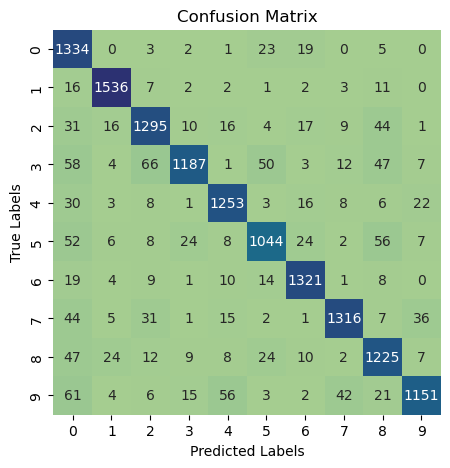

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1387
           1       0.96      0.97      0.97      1580
           2       0.90      0.90      0.90      1443
           3       0.95      0.83      0.88      1435
           4       0.91      0.93      0.92      1350
           5       0.89      0.85      0.87      1231
           6       0.93      0.95      0.94      1387
           7       0.94      0.90      0.92      1458
           8       0.86      0.90      0.88      1368
           9       0.94      0.85      0.89      1361

    accuracy                           0.90     14000
   macro avg       0.91      0.90      0.90     14000
weighted avg       0.91      0.90      0.90     14000



In [21]:
y_pred = clf.predict(X_test)
y_pred = np.argmax((y_pred > 0.5), axis=1)


print('Accuracy: ', accuracy_score(y_test, y_pred)*100)

cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();


print(classification_report(y_test, y_pred))

438/438 [==============================] - 0s 729us/step


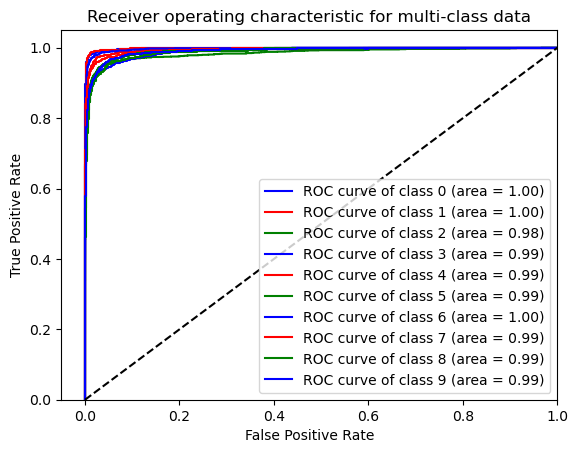

In [22]:
plot_auc_scores(clf, X_test, y_test, Y)

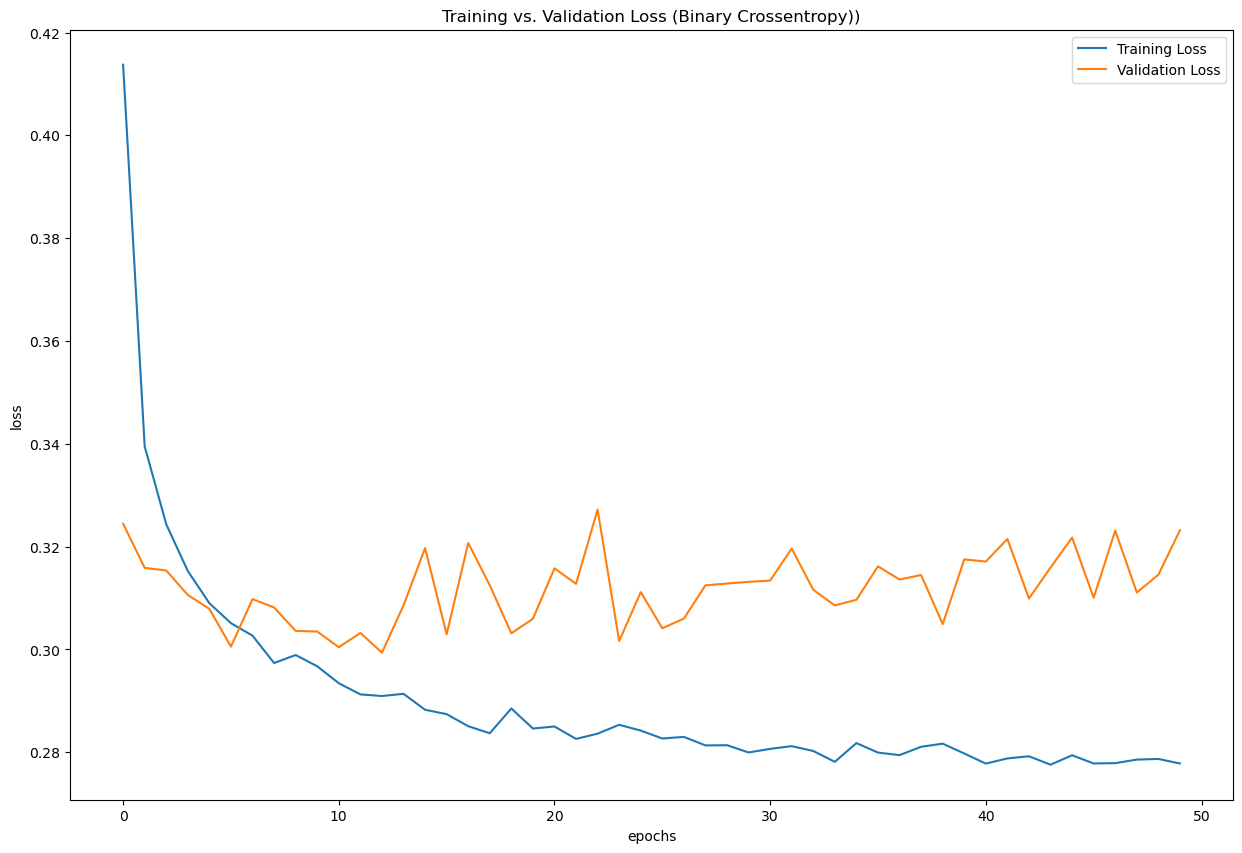

In [23]:
plt.figure(figsize=(15,10))
plt.plot(history.history[list(history.history.keys())[0]],label='Training Loss')
plt.plot(history.history[list(history.history.keys())[2]],label='Validation Loss')
plt.title(f'Training vs. Validation Loss (Binary Crossentropy))')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Max Train accuracy:  0.9240714311599731  | Max Val accuracy:  0.919785737991333


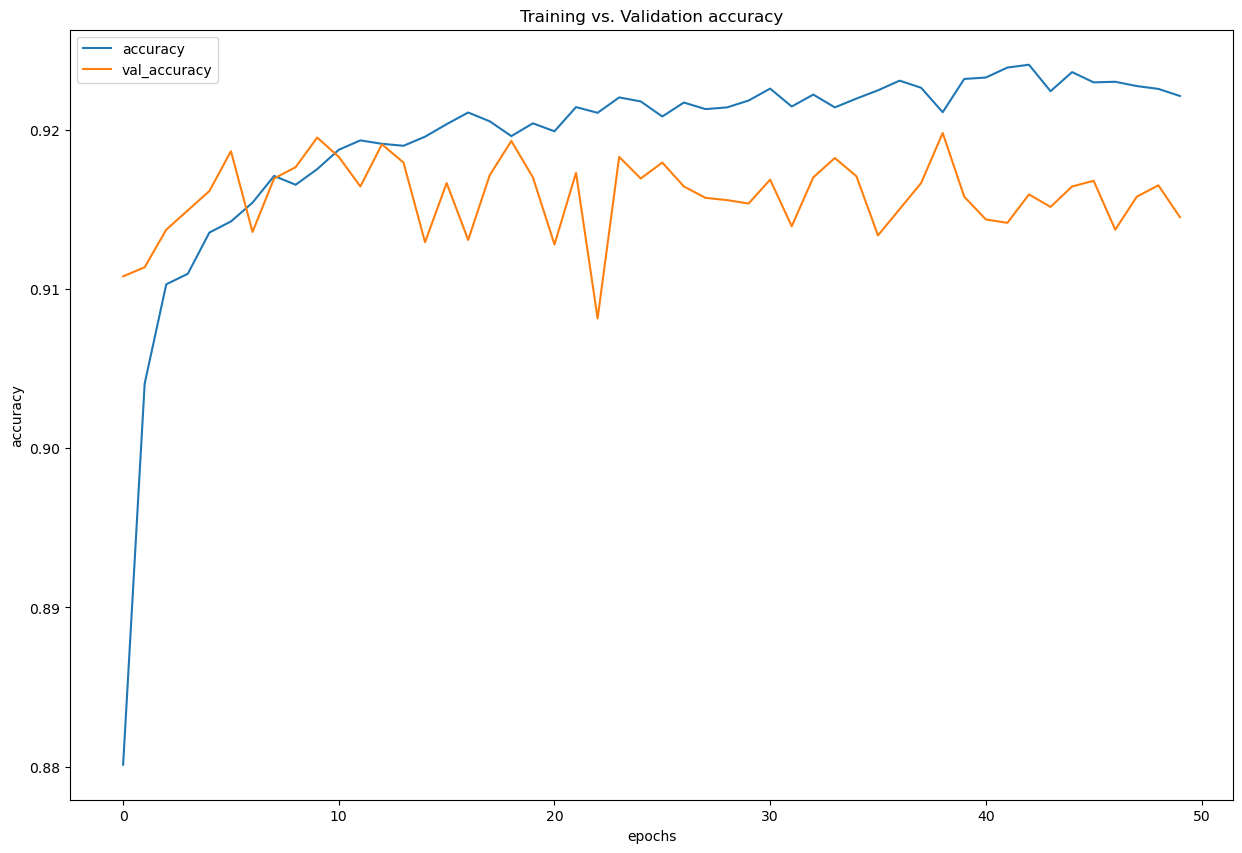

In [24]:
print(f'Max Train {list(history.history.keys())[1]}: ', max(history.history[list(history.history.keys())[1]]), f' | Max Val {list(history.history.keys())[1]}: ', max(history.history[list(history.history.keys())[-1]]))

plt.figure(figsize=(15,10))
plt.plot(history.history[list(history.history.keys())[1]],label=f'{list(history.history.keys())[1]}')
plt.plot(history.history[list(history.history.keys())[-1]],label=f'{list(history.history.keys())[-1]}')
plt.title(f'Training vs. Validation {list(history.history.keys())[1]}')
plt.xlabel('epochs')
plt.ylabel(f'{list(history.history.keys())[1]}')
# plt.ylim(0, 1)
plt.legend()
plt.show()

                                 No of columns: 3 | No. of rows: 5 | No. of samples: 15                                 


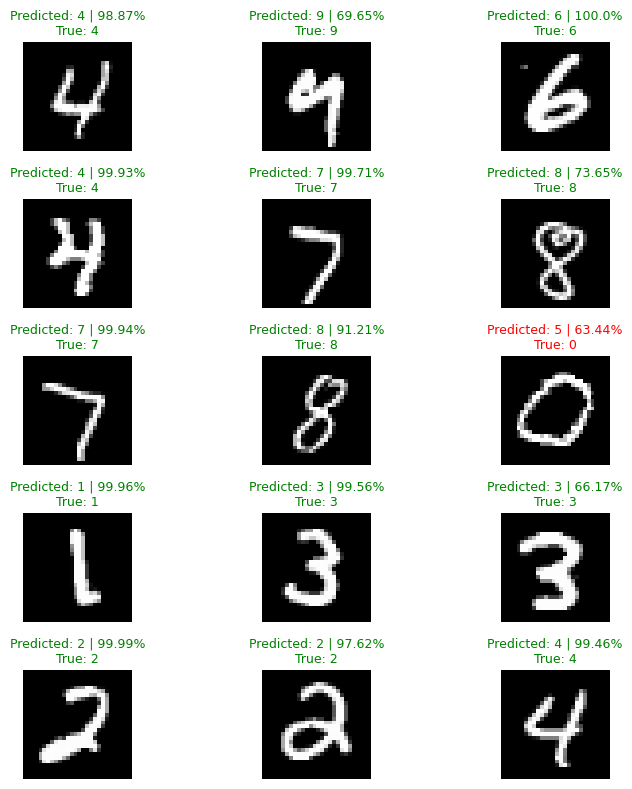

In [25]:
plot_random_predictions(model=clf, n_samples=15, width=8, height=8)